# Observing reconstruction images sequences (video image) by Spatio-Temporal Auto-Encoder.

This notebook demonstrates that the Spatio-Temporal Auto-Encoder can learn images and reconstruct its.  Image data set for this demo is about [Tennis player's motion](https://lmb.informatik.uni-freiburg.de/Publications/2011/Bro11a/)
.

Firstly, import Python and Cython modules for building Spatio-Temporal Auto-Encoder.

In [1]:
from pydbm.cnn.convolutional_neural_network import ConvolutionalNeuralNetwork
from pydbm.cnn.convolutionalneuralnetwork.residual_learning import ResidualLearning
from pydbm.cnn.convolutionalneuralnetwork.convolutional_auto_encoder import ConvolutionalAutoEncoder
from pydbm.cnn.spatio_temporal_auto_encoder import SpatioTemporalAutoEncoder
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer1
from pydbm.cnn.layerablecnn.convolution_layer import ConvolutionLayer as ConvolutionLayer2
from pydbm.cnn.featuregenerator.image_generator import ImageGenerator

In [2]:
from pydbm.activation.relu_function import ReLuFunction
from pydbm.activation.tanh_function import TanhFunction
from pydbm.activation.logistic_function import LogisticFunction
from pydbm.loss.mean_squared_error import MeanSquaredError
from pydbm.optimization.optparams.adam import Adam

In [3]:
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph1
from pydbm.synapse.cnn_graph import CNNGraph as ConvGraph2

In [4]:
from pydbm.rnn.lstm_model import LSTMModel as Encoder
from pydbm.rnn.lstm_model import LSTMModel as Decoder
from pydbm.optimization.optparams.adam import Adam as EncoderAdam
from pydbm.optimization.optparams.adam import Adam as DecoderAdam
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as EncoderGraph
from pydbm.synapse.recurrenttemporalgraph.lstm_graph import LSTMGraph as DecoderGraph

In [5]:
from pydbm.verification.verificate_function_approximation import VerificateFunctionApproximation

Set hyperparameters of feature points in image data.

In [6]:
batch_size = 20
seq_len = 5
channel = 1
height = 100
width = 100
scale = 0.1
enc_dim = 100
dec_dim = 100

Instantiate objects and call the method.

In [7]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("pydbm")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

In [8]:
# Init.
encoder_graph = EncoderGraph()

# Activation function in LSTM.
encoder_graph.observed_activating_function = TanhFunction()
encoder_graph.input_gate_activating_function = LogisticFunction()
encoder_graph.forget_gate_activating_function = LogisticFunction()
encoder_graph.output_gate_activating_function = LogisticFunction()
encoder_graph.hidden_activating_function = TanhFunction()
encoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
encoder_graph.create_rnn_cells(
    input_neuron_count=enc_dim,
    hidden_neuron_count=1000,
    output_neuron_count=enc_dim
)

# Optimizer for Encoder.
encoder_opt_params = EncoderAdam()
encoder_opt_params.weight_limit = 0.5
encoder_opt_params.dropout_rate = 0.5

encoder = Encoder(
    # Delegate `graph` to `LSTMModel`.
    graph=encoder_graph,
    # The number of epochs in mini-batch training.
    epochs=60,
    # The batch size.
    batch_size=batch_size,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=10,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=8,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=encoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    # Tolerance for the optimization.
    # When the loss or score is not improving by at least tol 
    # for two consecutive iterations, convergence is considered 
    # to be reached and training stops.
    tol=0.0,
    tld=1.0
)

In [9]:
# Init.
decoder_graph = DecoderGraph()

# Activation function in LSTM.
decoder_graph.observed_activating_function = TanhFunction()
decoder_graph.input_gate_activating_function = LogisticFunction()
decoder_graph.forget_gate_activating_function = LogisticFunction()
decoder_graph.output_gate_activating_function = LogisticFunction()
decoder_graph.hidden_activating_function = TanhFunction()
decoder_graph.output_activating_function = TanhFunction()

# Initialization strategy.
# This method initialize each weight matrices and biases in Gaussian distribution: `np.random.normal(size=hoge) * 0.01`.
decoder_graph.create_rnn_cells(
    input_neuron_count=1000,
    hidden_neuron_count=dec_dim,
    output_neuron_count=1000
)

# Optimizer for Decoder.
decoder_opt_params = DecoderAdam()
decoder_opt_params.weight_limit = 0.5
decoder_opt_params.dropout_rate = 0.5

decoder = Decoder(
    # Delegate `graph` to `LSTMModel`.
    graph=decoder_graph,
    # The number of epochs in mini-batch training.
    epochs=100,
    # The batch size.
    batch_size=batch_size,
    # Learning rate.
    learning_rate=1e-05,
    # Attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=0.1,
    # Attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # Refereed maxinum step `t` in BPTT. If `0`, this class referes all past data in BPTT.
    bptt_tau=8,
    # Size of Test data set. If this value is `0`, the validation will not be executed.
    test_size_rate=0.3,
    # Loss function.
    computable_loss=MeanSquaredError(),
    # Optimizer.
    opt_params=decoder_opt_params,
    # Verification function.
    verificatable_result=VerificateFunctionApproximation(),
    # Tolerance for the optimization.
    # When the loss or score is not improving by at least tol 
    # for two consecutive iterations, convergence is considered 
    # to be reached and training stops.
    tol=0.0
)

In [10]:
conv1 = ConvolutionLayer1(
    ConvGraph1(
        activation_function=TanhFunction(),
        filter_num=batch_size,
        channel=channel,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

conv2 = ConvolutionLayer2(
    ConvGraph2(
        activation_function=TanhFunction(),
        filter_num=batch_size,
        channel=batch_size,
        kernel_size=3,
        scale=scale,
        stride=1,
        pad=1
    )
)

cnn = SpatioTemporalAutoEncoder(
    layerable_cnn_list=[
        conv1, 
        conv2
    ],
    encoder=encoder,
    decoder=decoder,
    epochs=100,
    batch_size=batch_size,
    learning_rate=1e-05,
    learning_attenuate_rate=0.1,
    attenuate_epoch=25,
    computable_loss=MeanSquaredError(),
    opt_params=Adam(),
    verificatable_result=VerificateFunctionApproximation(),
    fully_connected_dim=100,
    fully_connected_activation=TanhFunction(),
    test_size_rate=0.3,
    tol=1e-15,
    save_flag=False
)

feature_generator = ImageGenerator(
    epochs=100,
    batch_size=batch_size,
    training_image_dir="../demo_local/img/training/",
    test_image_dir="../demo_local/img/test/",
    seq_len=seq_len,
    gray_scale_flag=True,
    wh_size_tuple=(height, width),
    norm_mode="z_score"
)

Setup CNN layers and the parameters.


Execute learning.

In [11]:
cnn.learn_generated(feature_generator)

CNN starts learning.
Generate training data: (20, 5, 1, 100, 100)
Generate test data: (20, 5, 1, 100, 100)
Encoder/Decoder's deltas are propagated.
Encoder/Decoder's best params are updated.
Convolutional Auto-Encoder's best params are updated.
----------------------------------------------------------------------------------------------------
Convolutional Auto-Encoder's loss:
Epoch: 1
Loss: 
Training: 0.397456471809 Test: 0.395307212262
----------------------------------------------------------------------------------------------------
Encoder/Decoder's loss: 
Training: 1.00045840308 Test: 1.02567640242
----------------------------------------------------------------------------------------------------
Generate training data: (20, 5, 1, 100, 100)
Generate test data: (20, 5, 1, 100, 100)
Encoder/Decoder's deltas are propagated.
----------------------------------------------------------------------------------------------------
Convolutional Auto-Encoder's loss:
Epoch: 2
Loss: 
Trainin

# Extract reconstruction images.

The object `cnn` which is-a `SpatioTemporalAutoEncoder` has a method `inference` to be able to reconstruct observed data points as feature points. The input test data and reconstructed data are as follows.

Generate training data: (20, 5, 1, 100, 100)
DEBUG:pydbm:Generate training data: (20, 5, 1, 100, 100)
Generate test data: (20, 5, 1, 100, 100)
DEBUG:pydbm:Generate test data: (20, 5, 1, 100, 100)


test data:


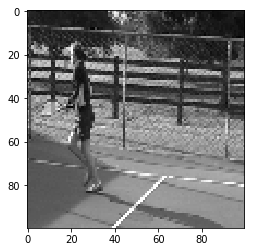

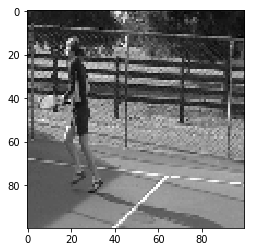

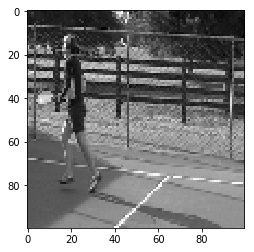

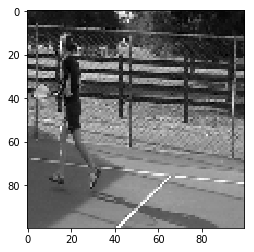

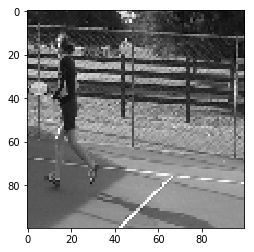

reconstructed data:


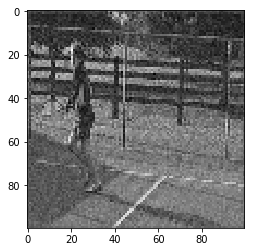

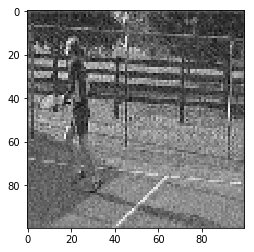

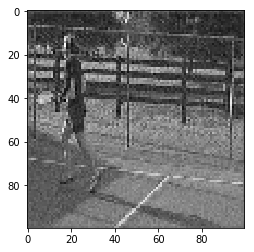

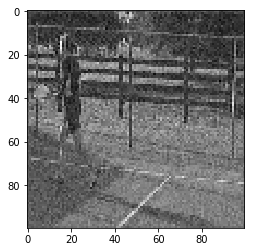

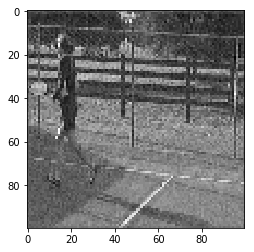

test data:


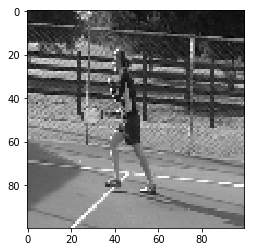

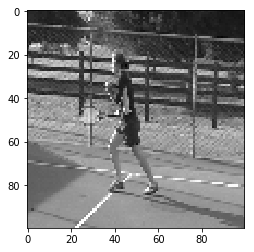

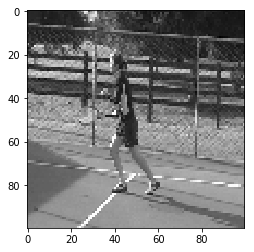

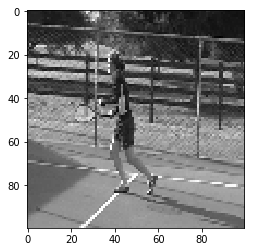

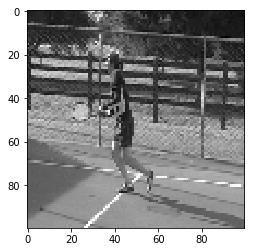

reconstructed data:


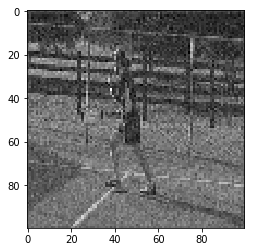

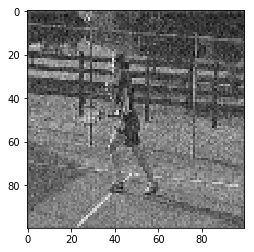

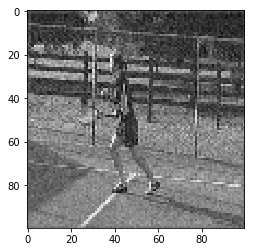

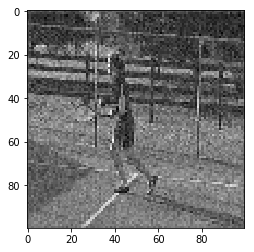

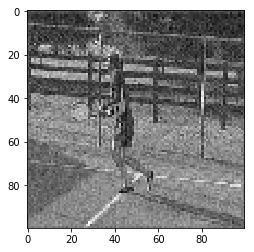

test data:


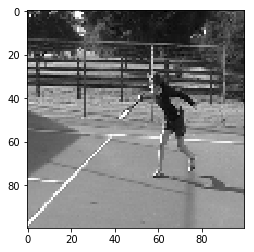

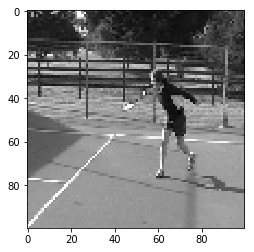

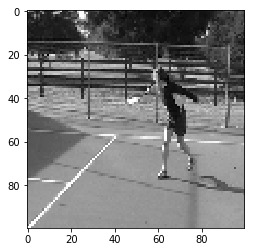

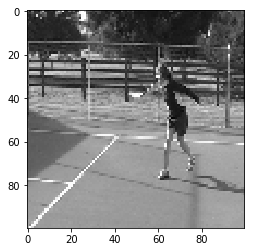

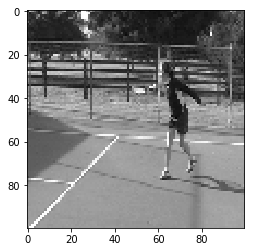

reconstructed data:


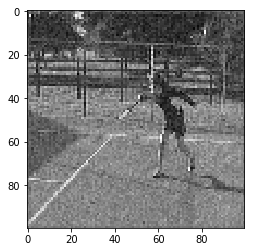

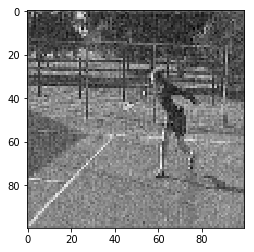

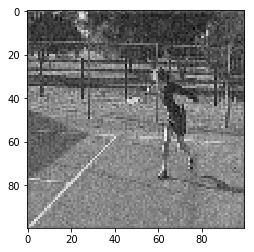

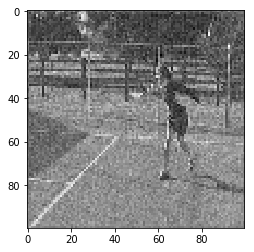

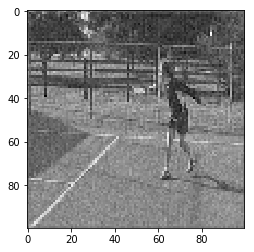

In [13]:
import matplotlib.pyplot as plt

test_len = 0
test_limit = 3

for batch_observed_arr, batch_target_arr, test_batch_observed_arr, test_batch_target_arr in feature_generator.generate():
    result_arr = cnn.inference(test_batch_observed_arr)
    for batch in range(test_batch_target_arr.shape[0]):
        test_len += 1
        print("test data:")
        for seq in range(test_batch_target_arr[batch].shape[0]):
            plt.imshow(test_batch_target_arr[batch][seq][0], cmap="gray")
            plt.show()
            plt.close()
        print("reconstructed data:")
        for seq in range(test_batch_target_arr[batch].shape[0]):
            plt.imshow(result_arr[batch][seq][0], cmap="gray")
            plt.show()
            plt.close()
        if test_len >= test_limit:
            break
    if test_len >= test_limit:
        break


# References

- Baccouche, M., Mamalet, F., Wolf, C., Garcia, C., & Baskurt, A. (2012, September). Spatio-Temporal Convolutional Sparse Auto-Encoder for Sequence Classification. In BMVC (pp. 1-12).
- Brox, T., & Malik, J. (2011). Large displacement optical flow: descriptor matching in variational motion estimation. IEEE transactions on pattern analysis and machine intelligence, 33(3), 500-513.
- Patraucean, V., Handa, A., & Cipolla, R. (2015). Spatio-temporal video autoencoder with differentiable memory. arXiv preprint arXiv:1511.06309.